In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import cv2
from PIL import Image
import numpy as np

from flame_utils.FLAME_PyTorch_bonseyes.FLAME import FLAME
from flame_utils.FLAME_PyTorch_bonseyes.config import get_config
import torch
from collections import namedtuple

In [3]:
def reproject_vertices(vertices, projection, view, img_height):
    # Reproject vertices to image
    ones = np.ones((vertices.shape[0], 1))
    vertices_proj = np.concatenate((vertices, ones), axis=1)
    vertices_proj = projection @ view @ vertices_proj.T
    vertices_proj[:2] = vertices_proj[:2] / vertices_proj[3]
    vertices_proj[1] = img_height - vertices_proj[1]
    vertices_proj = vertices_proj.T

    return vertices_proj[:, :3]

#### Loading Data

In [4]:
base_data_dir = "/root/datasets/DAD-3DHeadsDataset"
datatool_tag = "train"
path = f"{datatool_tag}"
path = os.path.join(base_data_dir, path)
path

###################

file_path = f"{path}/{datatool_tag}.json"
file_path = os.path.join(base_data_dir, file_path)
with open(file_path, 'r') as f:
  data_json = json.load(f)
len(data_json)

'/root/datasets/DAD-3DHeadsDataset/train'

37840

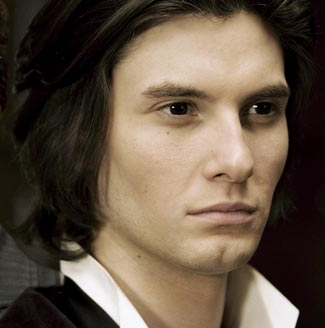

In [5]:
i = 26
item = data_json[i]

# Item attributes
annotation_path = item["annotation_path"].split(f"{datatool_tag}/")[-1]
img_path = item["img_path"].split(f"{datatool_tag}/")[-1]
bbox = item["bbox"]

img = Image.open(os.path.join(path, img_path))
img_width, img_height = img.size
img_arr = np.array(img)
img

with open(os.path.join(path, annotation_path), 'r') as f:
  source_data = json.load(f)

# Get annotations data
vertices = np.array(source_data["vertices"])
view = np.array(source_data["model_view_matrix"])
projection = np.array(source_data["projection_matrix"])

# Pre-process
vertices_proj = reproject_vertices(vertices.copy(), projection, view, img_height)
img_crop = img_arr[bbox[1] : bbox[1] + bbox[3], bbox[0] : bbox[0] + bbox[2], :]  # crop image
vertices_crop = vertices_proj.copy()
vertices_crop[:,0] -= bbox[0] # adjust vertices based on cropping 
vertices_crop[:,1] -= bbox[1]

#### Vertices 2 Landmarks using FLAME

In [6]:
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
flame_base_path = "./flame_utils/FLAME_PyTorch_bonseyes"

file_path = os.path.join(flame_base_path,"flame_config.json")
with open(file_path, 'r') as f:
  config = json.load(f)
config["device"] = device
config["flame_model_path"] = os.path.join(flame_base_path, config["flame_model_path"])
config["static_landmark_embedding_path"] = os.path.join(flame_base_path, config["static_landmark_embedding_path"])
config["dynamic_landmark_embedding_path"] = os.path.join(flame_base_path, config["dynamic_landmark_embedding_path"])
config = namedtuple('config', config.keys())(**config)

flamelayer = FLAME(config)

creating the FLAME Decoder


/root/dalvarez/SynergyNet_bonseyes/flame_utils/FLAME_PyTorch_bonseyes/FLAME.py:150: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  dynamic_lmk_bary_coords = torch.tensor(


... Finished FLAME Decoder creation


In [7]:
lms = flamelayer.vertices2landmarks(vertices_crop)
lms = lms[0].detach().cpu().numpy()
lms.shape

(51, 3)

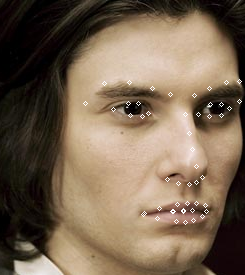

In [8]:
# Plot
img_plot = img_arr.copy()
img_vertices = lms.copy()

img_plot = img_crop.copy()
img_vertices = lms.copy()

step = 1
for coord in img_vertices[::step, :]:
    img_plot = cv2.circle(img_plot, (int(coord[0]), int(coord[1])), radius=2, color=(255,255,255))

# img_plot = cv2.cvtColor(img_plot, cv2.COLOR_RGB2BGR)
Image.fromarray(img_plot)

### Landmarks 2 FLAME Parameters

In [9]:
from flame_utils.flame_fitting_bonseyes.fitting.util import get_unit_factor
unit = 'm' # measurement unit of landmarks ['m', 'cm', 'mm']
scale_factor = get_unit_factor('m') / get_unit_factor(unit)
scale_factor

1.0

In [29]:
lms_sample[:3]
lms[:3]

array([[-0.0607802,  0.0309456,  0.0425312],
       [-0.0494252,  0.0369022,  0.0547772],
       [-0.0394189,  0.038468 ,  0.0599548]])

array([[ 85.79275 , 103.66503 ,  28.116657],
       [104.30203 ,  83.46416 ,  27.993969],
       [129.79015 ,  82.18931 ,  27.934769]], dtype=float32)

In [30]:
import sys
sys.path.append("./flame_utils/flame_fitting_bonseyes")
from flame_utils.flame_fitting_bonseyes.fit_lmk3d import fit_flame_to_lms

flame_base_path = "./flame_utils/flame_fitting_bonseyes"
lms_path = os.path.join(flame_base_path,"data/scan_lmks.npy")
lms_sample = np.load(lms_path)

lms_for_fit = lms_sample

maxiter = 2000
model_path = os.path.join(flame_base_path, "model/generic_model.pkl")
lmk_emb_path = os.path.join(flame_base_path, "model/flame_static_embedding.pkl")
mesh_v, mesh_f, params = fit_flame_to_lms(
                            lms_for_fit,
                            shape_num=100,
                            expr_num=50,
                            maxiter=maxiter,
                            model_path=model_path,
                            lmk_emb_path=lmk_emb_path,
                        )

params.keys()
pose = params["pose"]


step 1: start rigid fitting...


2.50e-02
1.74e-03
1.74e-03
1.74e-03
1.74e-03 | expr: 0.00e+00 | lmk: 1.74e-03 | pose: 0.00e+00 | shape: 0.00e+00


step 1: fitting done, in 3.668042 sec

step 2: start non-rigid fitting...


1.62e-03 | expr: 3.28e-09 | lmk: 1.62e-03 | pose: 8.75e-08 | shape: 5.84e-09
1.56e-03 | expr: 4.27e-08 | lmk: 1.56e-03 | pose: 9.28e-08 | shape: 7.66e-08
1.46e-03 | expr: 3.36e-07 | lmk: 1.46e-03 | pose: 1.09e-07 | shape: 6.05e-07
1.25e-03 | expr: 2.28e-06 | lmk: 1.24e-03 | pose: 1.67e-07 | shape: 4.14e-06
8.37e-04 | expr: 1.45e-05 | lmk: 7.95e-04 | pose: 4.05e-07 | shape: 2.69e-05
5.87e-04 | expr: 5.74e-05 | lmk: 4.17e-04 | pose: 1.02e-06 | shape: 1.12e-04
5.70e-04 | expr: 5.56e-05 | lmk: 4.02e-04 | pose: 8.75e-07 | shape: 1.12e-04


step 2: fitting done, in 39.934027 sec



5.70e-04 | expr: 5.60e-05 | lmk: 4.02e-04 | pose: 8.79e-07 | shape: 1.12e-04


dict_keys(['trans', 'pose', 'shape', 'expr', 'betas'])

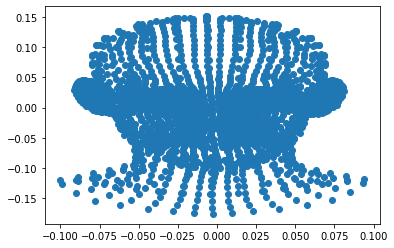

In [40]:
import matplotlib.pyplot as plt
plt.scatter(mesh_v[:,0], mesh_v[:,1])

In [44]:
pose = parms["pose"]
pose.shape
pose

(15,)

array([ 0.22330424,  0.01036037,  0.00578367,  0.        ,  0.        ,
        0.        ,  0.06341647, -0.01889791,  0.06643355,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [31]:
n = 100
step = 20
vertices_crop.shape
vertices_crop[:n:step]

mesh_v.shape
mesh_v[:n:step]

(5023, 3)

array([[217.3929539 , 149.20151695,  29.16295195],
       [ 31.92569615, 150.77795813,  28.69652738],
       [224.46479927, 187.93289604,  29.11676617],
       [234.00292238, 113.32467885,  29.35935682],
       [225.99736784, 129.21223186,  29.32545909]])

(5023, 3)

array([[ 0.05494854,  0.01210324, -0.00918537],
       [-0.06967851,  0.01313964, -0.01159142],
       [ 0.0610336 , -0.0099599 , -0.0041551 ],
       [ 0.07664679,  0.03950965, -0.01993647],
       [ 0.06878814,  0.02832481, -0.01578651]])

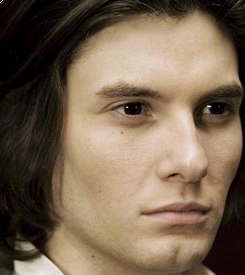

In [20]:
# Plot
img_plot = img_arr.copy()
img_vertices = vertices_proj.copy()

img_plot = img_crop.copy()
img_vertices = vertices_crop.copy()

img_plot = img_crop.copy()
img_vertices = mesh_v.copy()

step = 1
for coord in img_vertices[::step, :]:
    img_plot = cv2.circle(img_plot, (int(coord[0]), int(coord[1])), radius=2, color=(255,255,255))

# img_plot = cv2.cvtColor(img_plot, cv2.COLOR_RGB2BGR)
Image.fromarray(img_plot)